In [0]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
import cv2
from skimage import transform
from imageio import imread


In [44]:
#Hyperparameters

#Output Shape
resolution = (128,128)

# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

# Size of Patch for PatchGAN
patch = int(img_rows / 2**3)
disc_patch = (patch, patch, 1)

# Number of filters for G and D
filters_gen = 64

#Optimizer for the GAN.
optimizer = Adam(0.00015, 0.5)

# def load_images(dataset,batch_size):
#     chance = np.random.random()
#     path = glob('cityscapes/train/*')
#     images = np.random.choice(path, size=batch_size)
#     img_real = []
#     img_labelled = []

#     for imagepath in images:
#         img = cv2.imread(imagepath)
#         width = img.shape[1]
#         width = width//2
#         real_img, labelled_img = img[:, width:, :],img[:, :width, :]
#         real_img,labelled_img = transform.resize(real_img, resolution),transform.resize(labelled_img, resolution)
#         if (chance<0.5):
#             real_img = np.fliplr(real_img)
#             labelled_img = np.fliplr(labelled_img)
#         img_real.append(real_img)
#         img_labelled.append(labelled_img)
#     return np.array(img_labelled),np.array(img_real)

def load_images(dataset,batch_size,epoch):
    chance = np.random.random()
    path = glob('cityscapes/train/*')
#     images = np.random.choice(path, size=batch_size)
    images = path[epoch*batch_size:(epoch+1)*batch_size]
    img_real = []
    img_labelled = []
    for imagepath in images:
        img = imread(imagepath)
        width = img.shape[1]
        width = width//2
        real_img, labelled_img = img[:, width:, :],img[:, :width, :]
        real_img,labelled_img = transform.resize(real_img, resolution),transform.resize(labelled_img, resolution)
        if (chance<0.5):
            real_img = np.fliplr(real_img)
            labelled_img = np.fliplr(labelled_img)
        img_real.append(real_img)
        img_labelled.append(labelled_img)
    if(dataset=='55'):
        return np.array(img_real), np.array(img_labelled)
    return np.array(img_labelled), np.array(img_real)

# REMEBER! - arr1(A) is the actual truth. arr2(B) is the labelled graphical image

# for batch_i, (imgs_A, imgs_B) in enumerate(load_images(1,2)):
#     print("hey")
arr1,arr2 = load_images('1',32,12)
# arr1.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


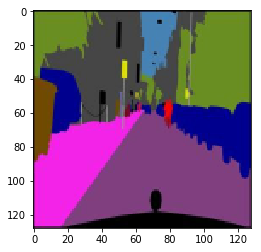

In [45]:
plt.imshow(arr2[6])
# path = glob('facades/train/*')
# len(path)
# arr1.shape

In [46]:
def new_generator():
    layer0 = Input(shape=img_shape,name="input")
    layer1 = Conv2D(filters_gen, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(layer0)
    bd = BatchNormalization(momentum=0.8)(layer1)
    layer2 = Conv2D(filters_gen*2, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer2)
    layer3 = Conv2D(filters_gen*4, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer3)
    layer4 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer4)
    layer5 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer5)
    layer6 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer6)
    dropout = Dropout(0.10)(bd)
    layer7 = Conv2D(filters_gen*8, kernel_size=2,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(dropout)
    bd = BatchNormalization(momentum=0.8)(layer7)
    def deconv2d(prev_layer, skip_input, filters):
        temp = UpSampling2D(size=2)(prev_layer)
        temp = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(temp)
        temp = BatchNormalization(momentum=0.6)(temp)
        temp = Concatenate()([temp, skip_input])
        return temp
    
    u_layer1 = deconv2d(bd, layer6, filters_gen*8)
    u_layer2 = deconv2d(u_layer1, layer5, filters_gen*8)
    u_layer3 = deconv2d(u_layer2, layer4, filters_gen*8)
    u_layer4 = deconv2d(u_layer3, layer3, filters_gen*4)
    dropout = Dropout(0.25)(u_layer4)
    u_layer5 = deconv2d(dropout, layer2, filters_gen*2)
    u_layer6 = deconv2d(u_layer5, layer1, filters_gen)
    u_layer7 = UpSampling2D(size=2)(u_layer6)
    u_layer0 = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u_layer7)
    return Model(layer0,u_layer0,name="Generator")


def new_discriminator():
    def d_layer(prev_layer, filters):
        temp = Conv2D(filters, kernel_size=4, strides=2, padding='same')(prev_layer)
        temp = LeakyReLU(alpha=0.2)(temp)
        return temp

    layer0_A = Input(shape=img_shape)
    layer0_B = Input(shape=img_shape)
    combined_input = Concatenate(axis=-1)([layer0_A, layer0_B])
    layer1 = d_layer(combined_input, filters_gen)
    layer2 = d_layer(layer1, filters_gen*2)
    layer3 = d_layer(layer2, filters_gen*4)
#     layer4 = d_layer(layer3, filters_gen*8)
    dropout = Dropout(0.25)(layer3)
    layer5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(dropout)
    return Model([layer0_A, layer0_B], layer5,name="Discriminator")

heaven = new_discriminator()
heaven.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
concatenate_35 (Concatenate)    (None, 128, 128, 6)  0           input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 64, 64, 64)   6208        concatenate_35[0][0]             
__________

In [47]:
'''
1. Two images as input.
2. One image goes to generator
3. Two images go to the discriminator as input
4. We freeze the discriminator weights
5. Create GAN with both models. Inputs - B (Labelled Graphical) as earlier and outputs (A - Ground Truth) as earlier
'''
#<---Since the model is being compiled already here, 
# the flag later of trainable = False does not affect it.--->
d = new_discriminator()
d.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])


g = new_generator()

input_image_A = Input(shape = img_shape)
input_image_B = Input(shape = img_shape)

fake_image_B = g(input_image_B)
validity = d([fake_image_B,input_image_B])

#THIS ONLY STOPS THE TRAINING OF THE DISCRIMINATOR IN THE GAN. IT WILL STILL TRAIN WHEN INVOKED AS JUST D.
d.trainable = False

gan = Model(inputs=[input_image_A,input_image_B],outputs = [validity,fake_image_B],name="GAN")

gan.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
gan.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 128, 128, 3)  38697859    input_34[0][0]                   
__________________________________________________________________________________________________
Discriminator (Model)           (None, 16, 16, 1)    666049      Generator[1][0]                  
                                                                 input_34[0][0]                   
Total params: 39,363,908
Trainable params: 38,688,899
Non-trainable params: 675,009
__________________________________________________________________________________________________


In [0]:
def plot_img():
    truth,labelled = load_images(1,1,1)
    predict = g.predict(labelled)
    plt.imshow(predict[0])
    plt.show()
    plt.imshow(truth[0])
    plt.show()

def train(epochs,batch_size):
    valid_scores = np.ones((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    fake_scores = np.zeros((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    for j in range(epochs):
        print("Epoch -",j+1)
        start = datetime.datetime.now()
        for i in range(0,85):
# begin
            images_A,images_B = load_images(1,batch_size,i)
            fake_images = g.predict(images_B)

            #Discriminator losses
            d_loss_real = d.train_on_batch([images_A,images_B],valid_scores)
            d_loss_fake = d.train_on_batch([fake_images,images_B],fake_scores)
            avg_d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #GAN losses
            gan_loss = gan.train_on_batch([images_A,images_B],[valid_scores,images_A])
# end
        print("Discriminator Loss = ",avg_d_loss[0], "Accuracy =",avg_d_loss[1]*100)
        print("GAN Loss = ",gan_loss[0])
        end = start_time = datetime.datetime.now()
        print("Time Elapsed",end-start,"\n")
        if(j%5==0):
            plot_img()
#     return avg_d_loss, gan_loss


Epoch - 1


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator Loss =  0.24693023 Accuracy = 55.35888671875
GAN Loss =  8.991169
Time Elapsed 0:01:21.205425 



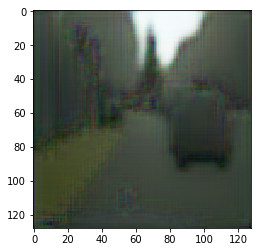

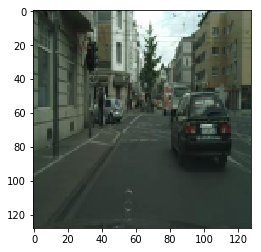

Epoch - 2
Discriminator Loss =  0.22182345 Accuracy = 62.98828125
GAN Loss =  8.855735
Time Elapsed 0:01:21.914839 

Epoch - 3
Discriminator Loss =  0.20371813 Accuracy = 66.351318359375
GAN Loss =  8.872487
Time Elapsed 0:01:20.841337 

Epoch - 4
Discriminator Loss =  0.18700576 Accuracy = 70.892333984375
GAN Loss =  8.688633
Time Elapsed 0:01:21.035969 

Epoch - 5
Discriminator Loss =  0.19338454 Accuracy = 70.1416015625
GAN Loss =  9.269538
Time Elapsed 0:01:20.990781 

Epoch - 6
Discriminator Loss =  0.17839213 Accuracy = 73.4619140625
GAN Loss =  8.736588
Time Elapsed 0:01:21.945837 



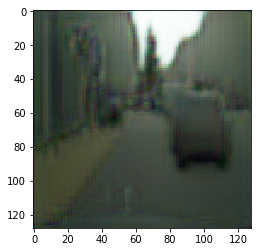

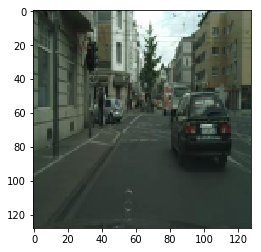

Epoch - 7
Discriminator Loss =  0.18358894 Accuracy = 72.314453125
GAN Loss =  8.917697
Time Elapsed 0:01:20.863615 

Epoch - 8
Discriminator Loss =  0.17775136 Accuracy = 73.66943359375
GAN Loss =  8.581889
Time Elapsed 0:01:21.149678 

Epoch - 9
Discriminator Loss =  0.1758818 Accuracy = 73.69384765625
GAN Loss =  8.395529
Time Elapsed 0:01:21.687303 

Epoch - 10
Discriminator Loss =  0.17639501 Accuracy = 74.017333984375
GAN Loss =  8.608388
Time Elapsed 0:01:21.429941 

Epoch - 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18423486 Accuracy = 73.0712890625
GAN Loss =  8.852982
Time Elapsed 0:01:20.888726 



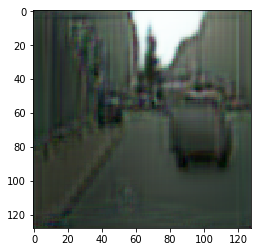

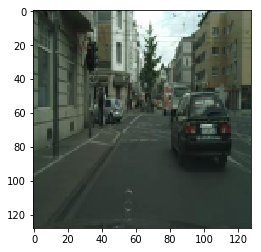

Epoch - 12
Discriminator Loss =  0.19614941 Accuracy = 71.197509765625
GAN Loss =  8.150853
Time Elapsed 0:01:21.107134 

Epoch - 13
Discriminator Loss =  0.19773144 Accuracy = 70.233154296875
GAN Loss =  7.980727
Time Elapsed 0:01:22.076866 

Epoch - 14
Discriminator Loss =  0.19468667 Accuracy = 71.19140625
GAN Loss =  7.702309
Time Elapsed 0:01:21.185431 

Epoch - 15
Discriminator Loss =  0.18458003 Accuracy = 71.978759765625
GAN Loss =  7.5675397
Time Elapsed 0:01:21.086508 

Epoch - 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.2038166 Accuracy = 68.536376953125
GAN Loss =  9.071967
Time Elapsed 0:01:20.954355 



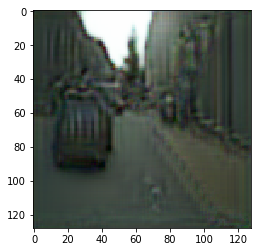

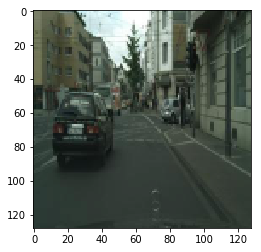

Epoch - 17
Discriminator Loss =  0.18385065 Accuracy = 73.199462890625
GAN Loss =  7.4188724
Time Elapsed 0:01:21.810353 

Epoch - 18
Discriminator Loss =  0.18851489 Accuracy = 72.1923828125
GAN Loss =  7.392915
Time Elapsed 0:01:20.937200 

Epoch - 19
Discriminator Loss =  0.18875407 Accuracy = 73.08349609375
GAN Loss =  7.8106704
Time Elapsed 0:01:20.851994 

Epoch - 20
Discriminator Loss =  0.1978379 Accuracy = 70.123291015625
GAN Loss =  7.2962847
Time Elapsed 0:01:21.003456 

Epoch - 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18626854 Accuracy = 72.64404296875
GAN Loss =  7.394513
Time Elapsed 0:01:21.383015 



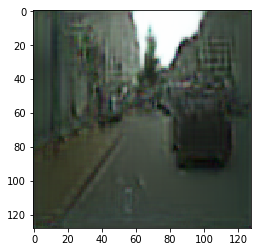

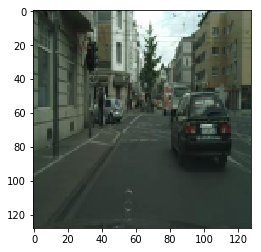

Epoch - 22
Discriminator Loss =  0.1701414 Accuracy = 76.50146484375
GAN Loss =  7.0312023
Time Elapsed 0:01:21.207856 

Epoch - 23
Discriminator Loss =  0.1787032 Accuracy = 74.237060546875
GAN Loss =  6.89894
Time Elapsed 0:01:21.269063 

Epoch - 24
Discriminator Loss =  0.18638715 Accuracy = 72.430419921875
GAN Loss =  7.2506957
Time Elapsed 0:01:21.419587 

Epoch - 25
Discriminator Loss =  0.19388418 Accuracy = 71.10595703125
GAN Loss =  7.048156
Time Elapsed 0:01:21.992720 

Epoch - 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18015404 Accuracy = 74.249267578125
GAN Loss =  6.917242
Time Elapsed 0:01:21.157199 



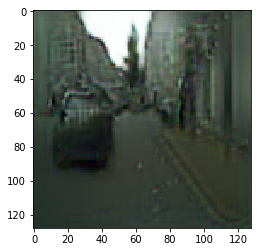

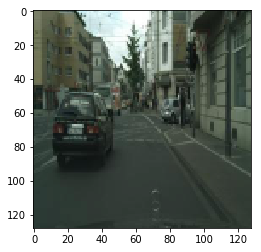

Epoch - 27
Discriminator Loss =  0.17126623 Accuracy = 75.201416015625
GAN Loss =  6.704999
Time Elapsed 0:01:21.434771 

Epoch - 28
Discriminator Loss =  0.1741972 Accuracy = 74.8046875
GAN Loss =  6.603023
Time Elapsed 0:01:21.654620 

Epoch - 29
Discriminator Loss =  0.18373871 Accuracy = 75.372314453125
GAN Loss =  6.900051
Time Elapsed 0:01:21.593123 

Epoch - 30
Discriminator Loss =  0.18806285 Accuracy = 72.955322265625
GAN Loss =  6.6088223
Time Elapsed 0:01:21.333534 

Epoch - 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.20850489 Accuracy = 67.962646484375
GAN Loss =  6.8490777
Time Elapsed 0:01:21.062194 



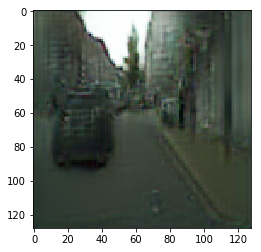

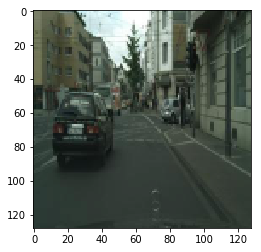

Epoch - 32
Discriminator Loss =  0.18885736 Accuracy = 71.844482421875
GAN Loss =  6.5869293
Time Elapsed 0:01:22.153451 

Epoch - 33
Discriminator Loss =  0.17450792 Accuracy = 76.019287109375
GAN Loss =  7.1730475
Time Elapsed 0:01:21.383567 

Epoch - 34
Discriminator Loss =  0.18301365 Accuracy = 73.504638671875
GAN Loss =  6.4722652
Time Elapsed 0:01:21.317129 

Epoch - 35
Discriminator Loss =  0.19036213 Accuracy = 71.2890625
GAN Loss =  6.442592
Time Elapsed 0:01:21.423249 

Epoch - 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.19604923 Accuracy = 70.465087890625
GAN Loss =  6.5992236
Time Elapsed 0:01:22.347419 



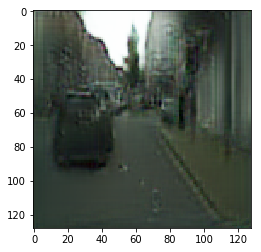

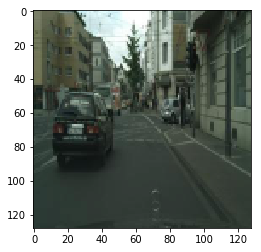

Epoch - 37
Discriminator Loss =  0.18785562 Accuracy = 72.259521484375
GAN Loss =  6.3722687
Time Elapsed 0:01:21.350738 

Epoch - 38
Discriminator Loss =  0.18858537 Accuracy = 72.247314453125
GAN Loss =  6.3725576
Time Elapsed 0:01:21.205960 

Epoch - 39
Discriminator Loss =  0.18025282 Accuracy = 74.35302734375
GAN Loss =  6.3146973
Time Elapsed 0:01:21.141026 

Epoch - 40
Discriminator Loss =  0.19079909 Accuracy = 71.15478515625
GAN Loss =  6.2612267
Time Elapsed 0:01:21.902864 

Epoch - 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18096897 Accuracy = 74.395751953125
GAN Loss =  6.273378
Time Elapsed 0:01:21.359785 



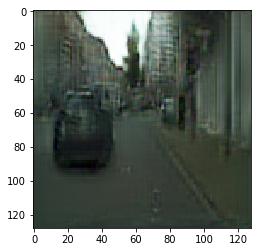

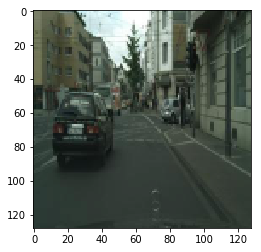

Epoch - 42
Discriminator Loss =  0.19261153 Accuracy = 71.075439453125
GAN Loss =  6.130633
Time Elapsed 0:01:21.119530 

Epoch - 43
Discriminator Loss =  0.1791767 Accuracy = 73.614501953125
GAN Loss =  6.066781
Time Elapsed 0:01:21.652971 

Epoch - 44
Discriminator Loss =  0.1738957 Accuracy = 74.798583984375
GAN Loss =  6.1842813
Time Elapsed 0:01:21.738747 

Epoch - 45
Discriminator Loss =  0.1814596 Accuracy = 73.6572265625
GAN Loss =  6.1245594
Time Elapsed 0:01:21.042422 

Epoch - 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18644977 Accuracy = 71.954345703125
GAN Loss =  5.909624
Time Elapsed 0:01:21.418205 



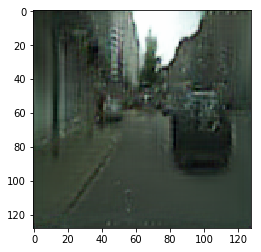

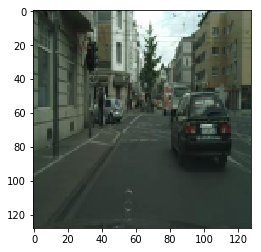

Epoch - 47
Discriminator Loss =  0.17981464 Accuracy = 73.64501953125
GAN Loss =  5.9045897
Time Elapsed 0:01:21.677230 

Epoch - 48
Discriminator Loss =  0.18191664 Accuracy = 72.979736328125
GAN Loss =  6.1699276
Time Elapsed 0:01:21.128867 

Epoch - 49
Discriminator Loss =  0.16484074 Accuracy = 77.117919921875
GAN Loss =  6.219659
Time Elapsed 0:01:21.006222 

Epoch - 50
Discriminator Loss =  0.1739846 Accuracy = 75.6591796875
GAN Loss =  5.9490023
Time Elapsed 0:01:20.999270 



In [52]:
# Begin Training
train(50,32)

Epoch - 1


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17936414 Accuracy = 73.394775390625
GAN Loss =  6.2337456
Time Elapsed 0:01:21.983448 



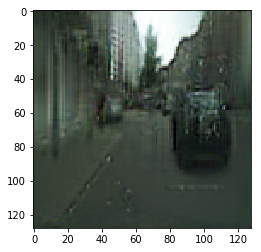

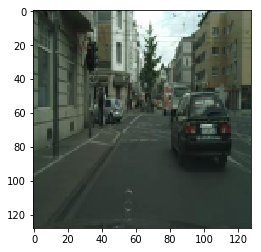

Epoch - 2
Discriminator Loss =  0.18381867 Accuracy = 72.5341796875
GAN Loss =  5.925203
Time Elapsed 0:01:20.946913 

Epoch - 3
Discriminator Loss =  0.18495005 Accuracy = 72.412109375
GAN Loss =  5.9620886
Time Elapsed 0:01:20.841354 

Epoch - 4
Discriminator Loss =  0.17912735 Accuracy = 73.42529296875
GAN Loss =  6.0239305
Time Elapsed 0:01:21.006002 

Epoch - 5
Discriminator Loss =  0.17234156 Accuracy = 75.0732421875
GAN Loss =  5.8820424
Time Elapsed 0:01:22.001881 

Epoch - 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17325416 Accuracy = 76.0498046875
GAN Loss =  5.7996902
Time Elapsed 0:01:20.864068 



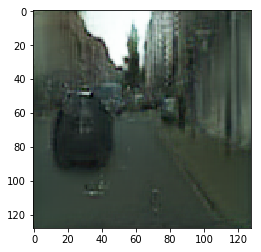

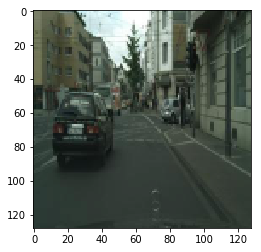

Epoch - 7
Discriminator Loss =  0.18043461 Accuracy = 73.431396484375
GAN Loss =  5.6764755
Time Elapsed 0:01:20.954474 

Epoch - 8
Discriminator Loss =  0.18813884 Accuracy = 70.709228515625
GAN Loss =  5.855749
Time Elapsed 0:01:20.951294 

Epoch - 9
Discriminator Loss =  0.1778144 Accuracy = 73.73046875
GAN Loss =  5.7770095
Time Elapsed 0:01:21.442301 

Epoch - 10
Discriminator Loss =  0.17459777 Accuracy = 75.7080078125
GAN Loss =  5.6648445
Time Elapsed 0:01:20.978806 

Epoch - 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1931467 Accuracy = 69.51904296875
GAN Loss =  5.7293677
Time Elapsed 0:01:21.004794 



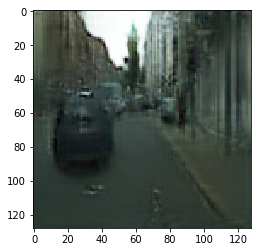

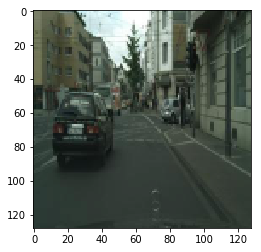

Epoch - 12
Discriminator Loss =  0.19092785 Accuracy = 70.245361328125
GAN Loss =  5.6364403
Time Elapsed 0:01:21.396314 

Epoch - 13
Discriminator Loss =  0.18334211 Accuracy = 72.955322265625
GAN Loss =  5.582361
Time Elapsed 0:01:21.794998 

Epoch - 14
Discriminator Loss =  0.17317714 Accuracy = 74.969482421875
GAN Loss =  5.6382394
Time Elapsed 0:01:21.032722 

Epoch - 15
Discriminator Loss =  0.17964119 Accuracy = 73.779296875
GAN Loss =  5.665724
Time Elapsed 0:01:21.220000 

Epoch - 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18068172 Accuracy = 73.046875
GAN Loss =  5.53532
Time Elapsed 0:01:21.292711 



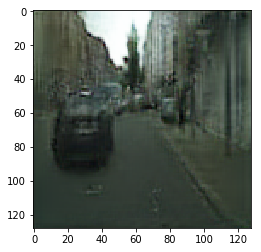

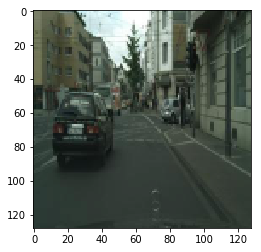

Epoch - 17
Discriminator Loss =  0.17779523 Accuracy = 74.298095703125
GAN Loss =  5.680626
Time Elapsed 0:01:21.680568 

Epoch - 18
Discriminator Loss =  0.18847668 Accuracy = 71.893310546875
GAN Loss =  5.519237
Time Elapsed 0:01:21.065889 

Epoch - 19
Discriminator Loss =  0.17901093 Accuracy = 74.79248046875
GAN Loss =  5.587096
Time Elapsed 0:01:20.977271 

Epoch - 20
Discriminator Loss =  0.19658953 Accuracy = 71.08154296875
GAN Loss =  5.5568886
Time Elapsed 0:01:21.931020 

Epoch - 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18068627 Accuracy = 73.84033203125
GAN Loss =  5.541572
Time Elapsed 0:01:20.834310 



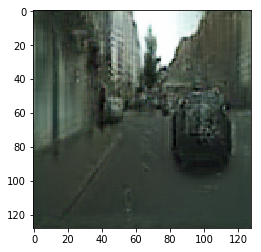

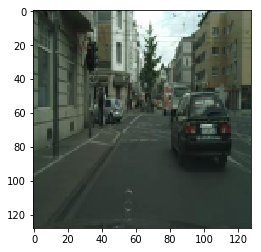

Epoch - 22
Discriminator Loss =  0.19063011 Accuracy = 71.160888671875
GAN Loss =  5.4463663
Time Elapsed 0:01:20.978606 

Epoch - 23
Discriminator Loss =  0.17670205 Accuracy = 74.90234375
GAN Loss =  5.457271
Time Elapsed 0:01:21.148170 

Epoch - 24
Discriminator Loss =  0.18266165 Accuracy = 73.870849609375
GAN Loss =  5.472886
Time Elapsed 0:01:20.801579 

Epoch - 25
Discriminator Loss =  0.17381194 Accuracy = 75.03662109375
GAN Loss =  5.574063
Time Elapsed 0:01:20.865998 

Epoch - 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17953996 Accuracy = 73.66943359375
GAN Loss =  5.606393
Time Elapsed 0:01:20.815478 



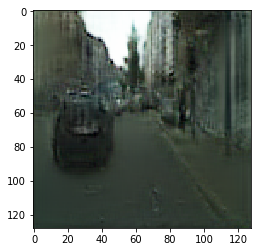

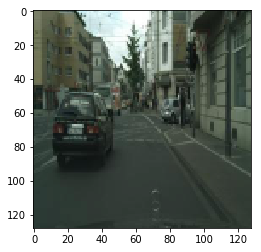

Epoch - 27
Discriminator Loss =  0.17718217 Accuracy = 74.31640625
GAN Loss =  5.5315537
Time Elapsed 0:01:20.844035 

Epoch - 28
Discriminator Loss =  0.17393275 Accuracy = 74.493408203125
GAN Loss =  5.669908
Time Elapsed 0:01:21.393994 

Epoch - 29
Discriminator Loss =  0.18256575 Accuracy = 73.406982421875
GAN Loss =  5.6071067
Time Elapsed 0:01:20.828649 

Epoch - 30
Discriminator Loss =  0.17915902 Accuracy = 73.736572265625
GAN Loss =  5.8183446
Time Elapsed 0:01:20.858541 

Epoch - 31
Discriminator Loss =  0.44541115 Accuracy = 24.74365234375
GAN Loss =  5.0054226
Time Elapsed 0:01:21.382226 



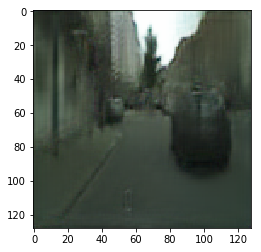

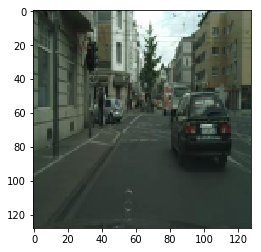

Epoch - 32
Discriminator Loss =  0.24394025 Accuracy = 58.4716796875
GAN Loss =  7.413135
Time Elapsed 0:01:21.819124 

Epoch - 33
Discriminator Loss =  0.21500054 Accuracy = 65.33203125
GAN Loss =  6.00142
Time Elapsed 0:01:21.020782 

Epoch - 34
Discriminator Loss =  0.20116475 Accuracy = 69.317626953125
GAN Loss =  5.5566883
Time Elapsed 0:01:21.250112 

Epoch - 35
Discriminator Loss =  0.19064605 Accuracy = 72.32666015625
GAN Loss =  5.3407125
Time Elapsed 0:01:21.224201 

Epoch - 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18604332 Accuracy = 72.9736328125
GAN Loss =  5.300495
Time Elapsed 0:01:21.700845 



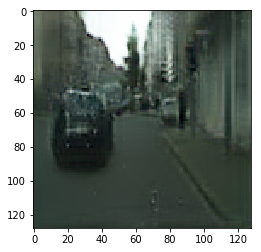

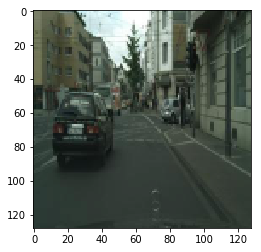

Epoch - 37
Discriminator Loss =  0.1823453 Accuracy = 73.907470703125
GAN Loss =  5.2128506
Time Elapsed 0:01:21.032170 

Epoch - 38
Discriminator Loss =  0.18855889 Accuracy = 72.003173828125
GAN Loss =  5.226124
Time Elapsed 0:01:21.182946 

Epoch - 39
Discriminator Loss =  0.166659 Accuracy = 77.728271484375
GAN Loss =  5.88499
Time Elapsed 0:01:21.077717 

Epoch - 40
Discriminator Loss =  0.17902751 Accuracy = 73.6572265625
GAN Loss =  5.943993
Time Elapsed 0:01:20.995945 

Epoch - 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.15877926 Accuracy = 79.21142578125
GAN Loss =  6.166044
Time Elapsed 0:01:20.739474 



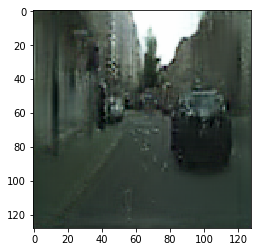

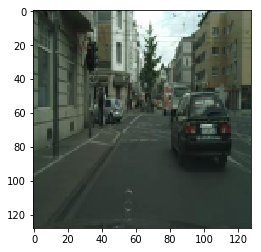

Epoch - 42
Discriminator Loss =  0.16634513 Accuracy = 77.685546875
GAN Loss =  5.7050495
Time Elapsed 0:01:21.079550 

Epoch - 43
Discriminator Loss =  0.17773306 Accuracy = 75.03662109375
GAN Loss =  5.430888
Time Elapsed 0:01:21.555647 

Epoch - 44
Discriminator Loss =  0.18012989 Accuracy = 73.858642578125
GAN Loss =  5.233841
Time Elapsed 0:01:20.951148 

Epoch - 45
Discriminator Loss =  0.17496309 Accuracy = 75.45166015625
GAN Loss =  5.5950284
Time Elapsed 0:01:20.888701 

Epoch - 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17932081 Accuracy = 74.37744140625
GAN Loss =  5.2373776
Time Elapsed 0:01:21.063593 



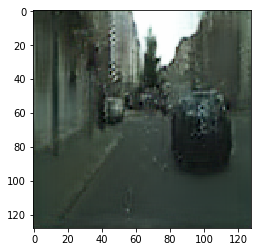

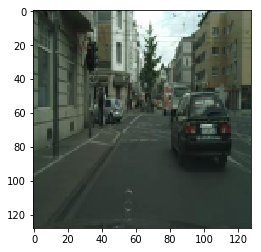

Epoch - 47
Discriminator Loss =  0.17365944 Accuracy = 75.567626953125
GAN Loss =  5.356853
Time Elapsed 0:01:21.273469 

Epoch - 48
Discriminator Loss =  0.17740807 Accuracy = 75.54931640625
GAN Loss =  5.1550846
Time Elapsed 0:01:20.563644 

Epoch - 49
Discriminator Loss =  0.17953253 Accuracy = 74.432373046875
GAN Loss =  5.140586
Time Elapsed 0:01:20.621888 

Epoch - 50
Discriminator Loss =  0.17389062 Accuracy = 75.52490234375
GAN Loss =  5.362383
Time Elapsed 0:01:20.981618 

Epoch - 51


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1723356 Accuracy = 75.6591796875
GAN Loss =  5.2383904
Time Elapsed 0:01:20.788417 



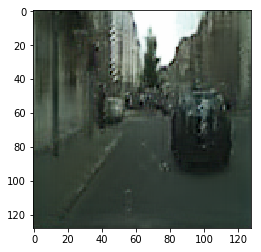

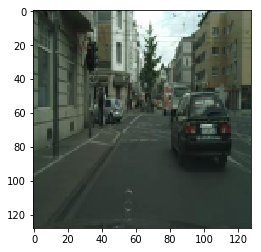

Epoch - 52
Discriminator Loss =  0.17099273 Accuracy = 76.35498046875
GAN Loss =  5.3914447
Time Elapsed 0:01:20.836290 

Epoch - 53
Discriminator Loss =  0.17762928 Accuracy = 75.250244140625
GAN Loss =  5.125766
Time Elapsed 0:01:20.876120 

Epoch - 54
Discriminator Loss =  0.17842479 Accuracy = 74.273681640625
GAN Loss =  5.1795855
Time Elapsed 0:01:20.855864 

Epoch - 55
Discriminator Loss =  0.18242314 Accuracy = 73.822021484375
GAN Loss =  5.112118
Time Elapsed 0:01:21.383800 

Epoch - 56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18393958 Accuracy = 73.22998046875
GAN Loss =  5.0570335
Time Elapsed 0:01:20.547922 



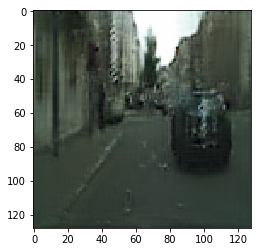

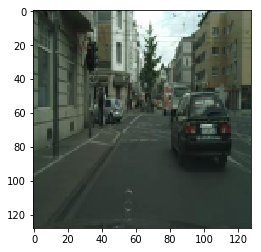

Epoch - 57
Discriminator Loss =  0.17717071 Accuracy = 74.468994140625
GAN Loss =  5.1080976
Time Elapsed 0:01:20.983471 

Epoch - 58
Discriminator Loss =  0.19067827 Accuracy = 71.728515625
GAN Loss =  5.2391787
Time Elapsed 0:01:20.636253 

Epoch - 59
Discriminator Loss =  0.18132183 Accuracy = 73.0712890625
GAN Loss =  5.153729
Time Elapsed 0:01:21.166306 

Epoch - 60
Discriminator Loss =  0.18285128 Accuracy = 73.71826171875
GAN Loss =  5.3570333
Time Elapsed 0:01:20.532925 

Epoch - 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1763111 Accuracy = 74.8291015625
GAN Loss =  4.9982076
Time Elapsed 0:01:20.826688 



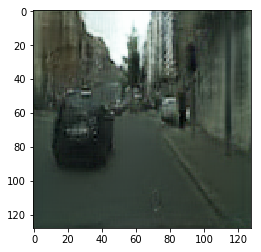

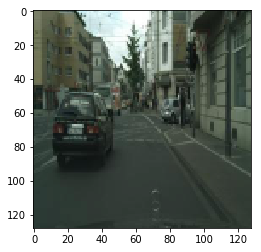

Epoch - 62
Discriminator Loss =  0.17948583 Accuracy = 74.2431640625
GAN Loss =  4.977124
Time Elapsed 0:01:20.999221 

Epoch - 63
Discriminator Loss =  0.170818 Accuracy = 74.786376953125
GAN Loss =  7.589701
Time Elapsed 0:01:20.904838 

Epoch - 64
Discriminator Loss =  0.18616906 Accuracy = 72.1435546875
GAN Loss =  5.8816156
Time Elapsed 0:01:20.576169 

Epoch - 65
Discriminator Loss =  0.17640969 Accuracy = 74.64599609375
GAN Loss =  5.433221
Time Elapsed 0:01:20.752326 

Epoch - 66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1906155 Accuracy = 71.612548828125
GAN Loss =  5.258346
Time Elapsed 0:01:21.201371 



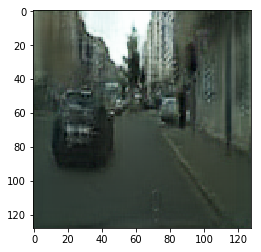

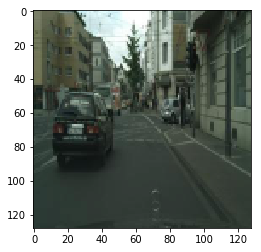

Epoch - 67
Discriminator Loss =  0.17380339 Accuracy = 75.433349609375
GAN Loss =  5.6749024
Time Elapsed 0:01:20.763319 

Epoch - 68
Discriminator Loss =  0.17472218 Accuracy = 74.853515625
GAN Loss =  5.3508863
Time Elapsed 0:01:20.846264 

Epoch - 69
Discriminator Loss =  0.18342125 Accuracy = 72.869873046875
GAN Loss =  5.2181315
Time Elapsed 0:01:21.103823 

Epoch - 70
Discriminator Loss =  0.18996873 Accuracy = 70.806884765625
GAN Loss =  5.053038
Time Elapsed 0:01:21.314787 

Epoch - 71


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18812741 Accuracy = 71.22802734375
GAN Loss =  5.0490804
Time Elapsed 0:01:20.823608 



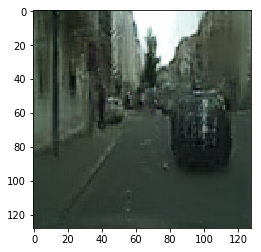

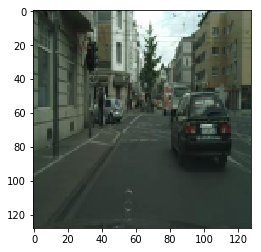

Epoch - 72
Discriminator Loss =  0.18760306 Accuracy = 71.575927734375
GAN Loss =  4.966816
Time Elapsed 0:01:21.448737 

Epoch - 73
Discriminator Loss =  0.174618 Accuracy = 74.91455078125
GAN Loss =  5.3636413
Time Elapsed 0:01:20.895892 

Epoch - 74
Discriminator Loss =  0.18389979 Accuracy = 72.44873046875
GAN Loss =  4.998204
Time Elapsed 0:01:21.562592 

Epoch - 75
Discriminator Loss =  0.18306419 Accuracy = 73.834228515625
GAN Loss =  4.9078135
Time Elapsed 0:01:20.775528 

Epoch - 76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1832014 Accuracy = 73.077392578125
GAN Loss =  4.8838487
Time Elapsed 0:01:21.266944 



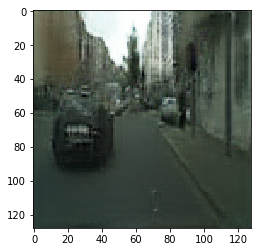

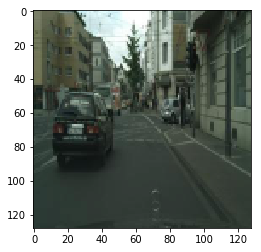

Epoch - 77
Discriminator Loss =  0.17842907 Accuracy = 74.371337890625
GAN Loss =  6.073305
Time Elapsed 0:01:20.837091 

Epoch - 78
Discriminator Loss =  0.17496333 Accuracy = 74.47509765625
GAN Loss =  5.280835
Time Elapsed 0:01:21.116134 

Epoch - 79
Discriminator Loss =  0.17557596 Accuracy = 74.7802734375
GAN Loss =  5.580351
Time Elapsed 0:01:20.804071 

Epoch - 80
Discriminator Loss =  0.18481493 Accuracy = 72.18017578125
GAN Loss =  5.0609713
Time Elapsed 0:01:21.088060 

Epoch - 81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18087411 Accuracy = 73.30322265625
GAN Loss =  4.945057
Time Elapsed 0:01:20.779511 



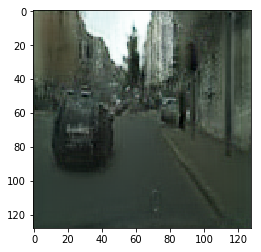

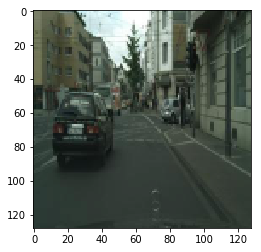

Epoch - 82
Discriminator Loss =  0.17576268 Accuracy = 74.609375
GAN Loss =  5.3143315
Time Elapsed 0:01:21.583487 

Epoch - 83
Discriminator Loss =  0.18103924 Accuracy = 73.18115234375
GAN Loss =  4.913202
Time Elapsed 0:01:20.866905 

Epoch - 84
Discriminator Loss =  0.16872576 Accuracy = 76.15966796875
GAN Loss =  5.231493
Time Elapsed 0:01:21.263686 

Epoch - 85
Discriminator Loss =  0.16452862 Accuracy = 77.1484375
GAN Loss =  5.317897
Time Elapsed 0:01:21.510943 

Epoch - 86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17750463 Accuracy = 74.49951171875
GAN Loss =  5.1442094
Time Elapsed 0:01:20.928439 



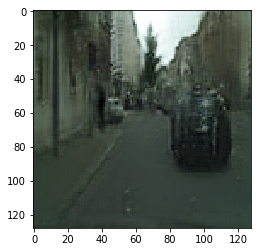

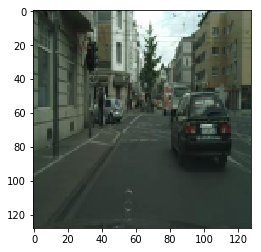

Epoch - 87
Discriminator Loss =  0.17120758 Accuracy = 75.86669921875
GAN Loss =  5.0851383
Time Elapsed 0:01:21.395495 

Epoch - 88
Discriminator Loss =  0.17716716 Accuracy = 74.67041015625
GAN Loss =  5.0768476
Time Elapsed 0:01:20.898529 

Epoch - 89
Discriminator Loss =  0.17788309 Accuracy = 74.700927734375
GAN Loss =  4.923848
Time Elapsed 0:01:21.795457 

Epoch - 90
Discriminator Loss =  0.1842576 Accuracy = 72.698974609375
GAN Loss =  4.992551
Time Elapsed 0:01:20.973331 

Epoch - 91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1716646 Accuracy = 75.89111328125
GAN Loss =  4.98601
Time Elapsed 0:01:21.354966 



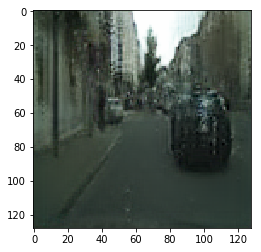

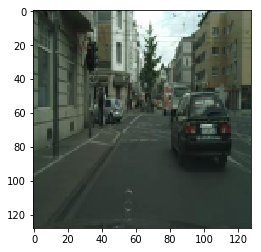

Epoch - 92
Discriminator Loss =  0.16857687 Accuracy = 76.220703125
GAN Loss =  5.1556683
Time Elapsed 0:01:20.975021 

Epoch - 93
Discriminator Loss =  0.17618155 Accuracy = 74.4140625
GAN Loss =  4.912311
Time Elapsed 0:01:21.814076 

Epoch - 94
Discriminator Loss =  0.16848963 Accuracy = 76.42822265625
GAN Loss =  5.058905
Time Elapsed 0:01:21.092210 

Epoch - 95
Discriminator Loss =  0.18111312 Accuracy = 73.419189453125
GAN Loss =  4.876151
Time Elapsed 0:01:21.642373 

Epoch - 96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17629889 Accuracy = 75.15869140625
GAN Loss =  4.815533
Time Elapsed 0:01:21.154240 



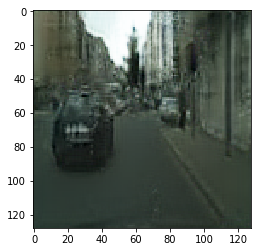

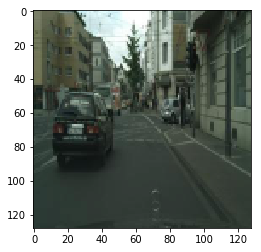

Epoch - 97
Discriminator Loss =  0.17857876 Accuracy = 73.33984375
GAN Loss =  4.8032804
Time Elapsed 0:01:21.474214 

Epoch - 98
Discriminator Loss =  0.16596752 Accuracy = 77.130126953125
GAN Loss =  5.048498
Time Elapsed 0:01:20.841969 

Epoch - 99
Discriminator Loss =  0.16838221 Accuracy = 76.153564453125
GAN Loss =  5.0337787
Time Elapsed 0:01:20.897492 

Epoch - 100
Discriminator Loss =  0.17205872 Accuracy = 75.4150390625
GAN Loss =  4.961487
Time Elapsed 0:01:20.821365 

Epoch - 101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.16990307 Accuracy = 76.06201171875
GAN Loss =  5.010813
Time Elapsed 0:01:21.527807 



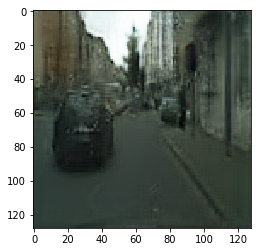

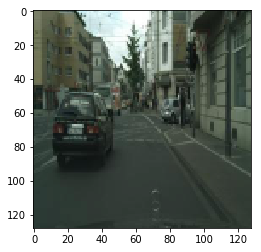

Epoch - 102
Discriminator Loss =  0.16725288 Accuracy = 76.98974609375
GAN Loss =  4.945922
Time Elapsed 0:01:21.308659 

Epoch - 103
Discriminator Loss =  0.1796994 Accuracy = 73.193359375
GAN Loss =  4.8812947
Time Elapsed 0:01:21.077654 

Epoch - 104
Discriminator Loss =  0.18188393 Accuracy = 73.712158203125
GAN Loss =  4.944629
Time Elapsed 0:01:20.927683 

Epoch - 105
Discriminator Loss =  0.22591318 Accuracy = 63.0126953125
GAN Loss =  6.704123
Time Elapsed 0:01:21.204301 

Epoch - 106
Discriminator Loss =  0.20525736 Accuracy = 71.966552734375
GAN Loss =  5.5194325
Time Elapsed 0:01:21.186162 



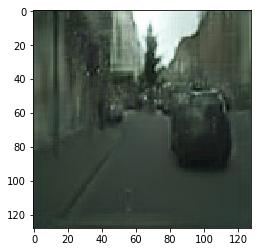

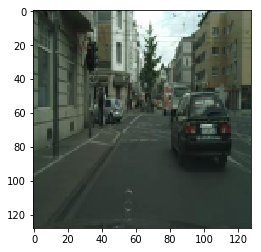

Epoch - 107
Discriminator Loss =  0.18228084 Accuracy = 73.71826171875
GAN Loss =  5.654701
Time Elapsed 0:01:20.851435 

Epoch - 108
Discriminator Loss =  0.17027763 Accuracy = 76.422119140625
GAN Loss =  5.1323905
Time Elapsed 0:01:21.346655 

Epoch - 109
Discriminator Loss =  0.1645145 Accuracy = 78.5400390625
GAN Loss =  5.148108
Time Elapsed 0:01:20.828167 

Epoch - 110
Discriminator Loss =  0.16141967 Accuracy = 78.955078125
GAN Loss =  5.0186176
Time Elapsed 0:01:21.282991 

Epoch - 111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.15618348 Accuracy = 80.194091796875
GAN Loss =  4.9476333
Time Elapsed 0:01:20.916311 



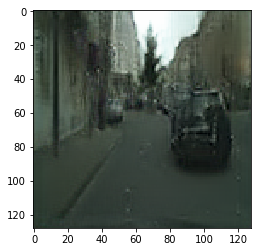

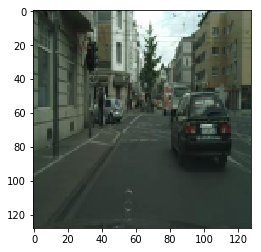

Epoch - 112
Discriminator Loss =  0.160258 Accuracy = 78.8330078125
GAN Loss =  4.97544
Time Elapsed 0:01:21.817475 

Epoch - 113
Discriminator Loss =  0.16183344 Accuracy = 78.759765625
GAN Loss =  4.9459414
Time Elapsed 0:01:20.851138 

Epoch - 114
Discriminator Loss =  0.16426942 Accuracy = 78.22265625
GAN Loss =  4.9706607
Time Elapsed 0:01:21.316695 

Epoch - 115
Discriminator Loss =  0.16841194 Accuracy = 77.276611328125
GAN Loss =  4.8845615
Time Elapsed 0:01:21.274909 

Epoch - 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.16177219 Accuracy = 78.564453125
GAN Loss =  4.845441
Time Elapsed 0:01:22.168565 



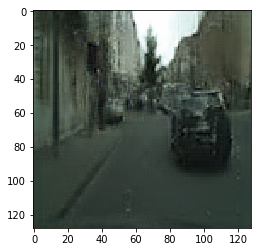

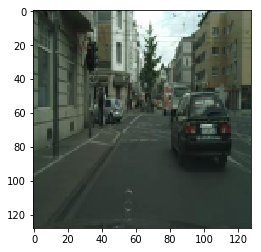

Epoch - 117
Discriminator Loss =  0.16326304 Accuracy = 78.460693359375
GAN Loss =  4.9412975
Time Elapsed 0:01:21.213419 

Epoch - 118
Discriminator Loss =  0.16203061 Accuracy = 78.38134765625
GAN Loss =  4.893015
Time Elapsed 0:01:20.964190 

Epoch - 119
Discriminator Loss =  0.16852905 Accuracy = 76.544189453125
GAN Loss =  4.7655816
Time Elapsed 0:01:20.885964 

Epoch - 120
Discriminator Loss =  0.16638452 Accuracy = 77.3193359375
GAN Loss =  4.846094
Time Elapsed 0:01:21.651859 

Epoch - 121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.16110721 Accuracy = 78.1982421875
GAN Loss =  4.82193
Time Elapsed 0:01:21.328711 



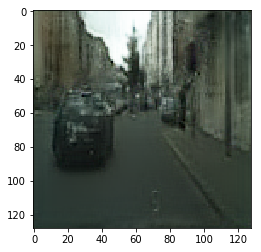

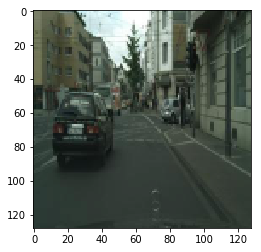

Epoch - 122
Discriminator Loss =  0.17022821 Accuracy = 76.9775390625
GAN Loss =  4.9755397
Time Elapsed 0:01:21.126623 

Epoch - 123
Discriminator Loss =  0.16657574 Accuracy = 77.1240234375
GAN Loss =  4.8144264
Time Elapsed 0:01:21.203430 

Epoch - 124
Discriminator Loss =  0.17977837 Accuracy = 73.86474609375
GAN Loss =  4.8276124
Time Elapsed 0:01:21.906337 

Epoch - 125
Discriminator Loss =  0.17864099 Accuracy = 74.810791015625
GAN Loss =  4.759795
Time Elapsed 0:01:21.506880 

Epoch - 126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17733969 Accuracy = 74.84130859375
GAN Loss =  4.9621725
Time Elapsed 0:01:21.228874 



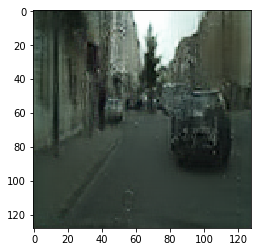

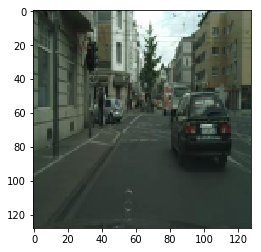

Epoch - 127
Discriminator Loss =  0.17061485 Accuracy = 76.416015625
GAN Loss =  4.942467
Time Elapsed 0:01:21.637019 

Epoch - 128
Discriminator Loss =  0.17111284 Accuracy = 76.25732421875
GAN Loss =  4.7930536
Time Elapsed 0:01:21.284724 

Epoch - 129
Discriminator Loss =  0.17200361 Accuracy = 76.043701171875
GAN Loss =  4.783785
Time Elapsed 0:01:21.488698 

Epoch - 130
Discriminator Loss =  0.1811097 Accuracy = 73.25439453125
GAN Loss =  4.7535915
Time Elapsed 0:01:21.210373 

Epoch - 131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17401594 Accuracy = 75.42724609375
GAN Loss =  4.7714434
Time Elapsed 0:01:21.714026 



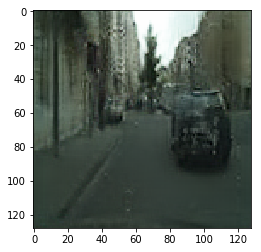

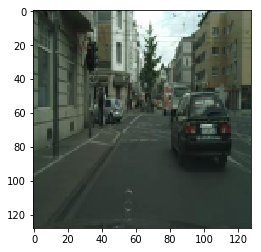

Epoch - 132
Discriminator Loss =  0.1775221 Accuracy = 74.67041015625
GAN Loss =  4.8619237
Time Elapsed 0:01:21.954464 

Epoch - 133
Discriminator Loss =  0.18076488 Accuracy = 74.06005859375
GAN Loss =  4.761413
Time Elapsed 0:01:21.766585 

Epoch - 134
Discriminator Loss =  0.18138117 Accuracy = 73.101806640625
GAN Loss =  4.746381
Time Elapsed 0:01:21.910014 

Epoch - 135
Discriminator Loss =  0.17907998 Accuracy = 74.755859375
GAN Loss =  4.7063327
Time Elapsed 0:01:21.911175 

Epoch - 136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.18472916 Accuracy = 72.86376953125
GAN Loss =  4.768674
Time Elapsed 0:01:21.615399 



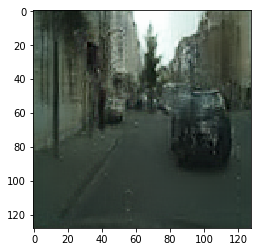

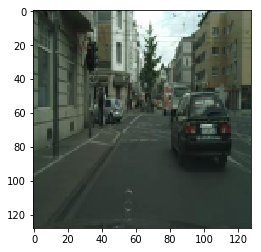

Epoch - 137
Discriminator Loss =  0.1816989 Accuracy = 73.73046875
GAN Loss =  4.8272376
Time Elapsed 0:01:21.133660 

Epoch - 138
Discriminator Loss =  0.17201653 Accuracy = 75.958251953125
GAN Loss =  4.681309
Time Elapsed 0:01:21.140605 

Epoch - 139
Discriminator Loss =  0.1750323 Accuracy = 74.62158203125
GAN Loss =  4.643154
Time Elapsed 0:01:21.664935 

Epoch - 140
Discriminator Loss =  0.1685749 Accuracy = 76.69677734375
GAN Loss =  4.899307
Time Elapsed 0:01:21.439970 

Epoch - 141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.17834562 Accuracy = 73.699951171875
GAN Loss =  4.836467
Time Elapsed 0:01:21.016574 



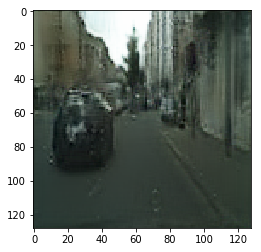

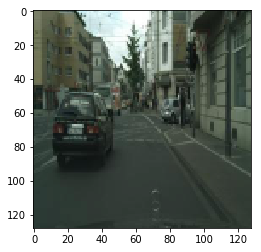

Epoch - 142
Discriminator Loss =  0.17789587 Accuracy = 74.505615234375
GAN Loss =  4.83822
Time Elapsed 0:01:21.127737 

Epoch - 143
Discriminator Loss =  0.17402065 Accuracy = 76.055908203125
GAN Loss =  4.78267
Time Elapsed 0:01:21.933013 

Epoch - 144
Discriminator Loss =  0.17873341 Accuracy = 73.9501953125
GAN Loss =  4.7410398
Time Elapsed 0:01:21.641871 

Epoch - 145
Discriminator Loss =  0.1808863 Accuracy = 73.980712890625
GAN Loss =  4.707198
Time Elapsed 0:01:21.120040 

Epoch - 146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss =  0.1774656 Accuracy = 74.462890625
GAN Loss =  4.7449765
Time Elapsed 0:01:21.387961 



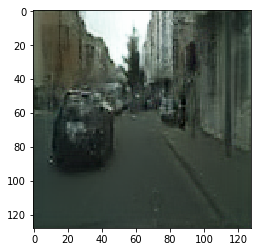

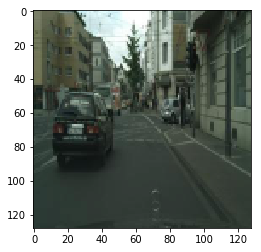

Epoch - 147
Discriminator Loss =  0.1836065 Accuracy = 73.03466796875
GAN Loss =  4.8071027
Time Elapsed 0:01:21.630659 

Epoch - 148
Discriminator Loss =  0.16785115 Accuracy = 76.1474609375
GAN Loss =  4.7725677
Time Elapsed 0:01:20.932814 

Epoch - 149
Discriminator Loss =  0.17554507 Accuracy = 75.445556640625
GAN Loss =  4.767647
Time Elapsed 0:01:20.969113 

Epoch - 150
Discriminator Loss =  0.17880258 Accuracy = 74.322509765625
GAN Loss =  4.751002
Time Elapsed 0:01:21.447547 



In [54]:
train(150,32)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


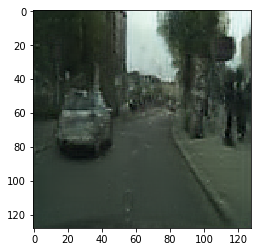

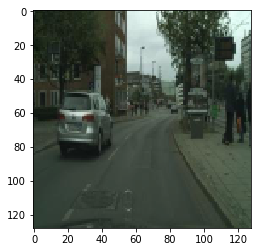

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


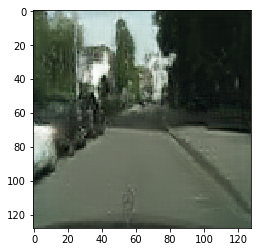

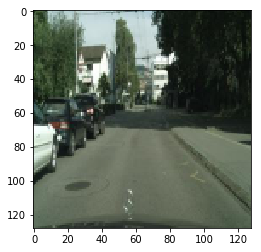

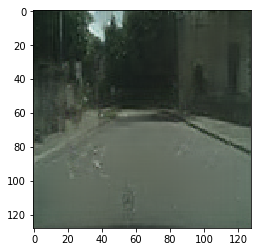

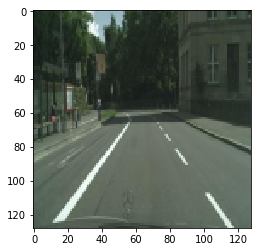

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


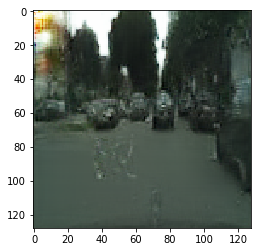

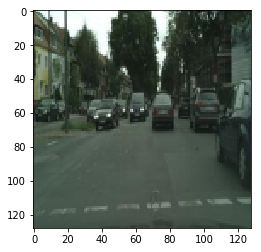

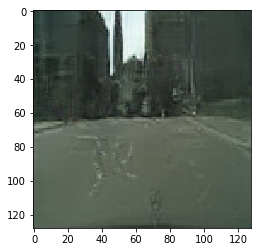

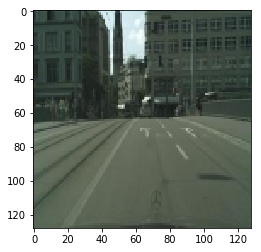

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


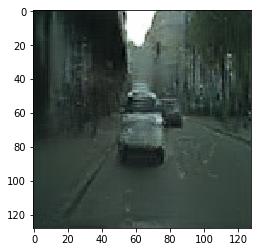

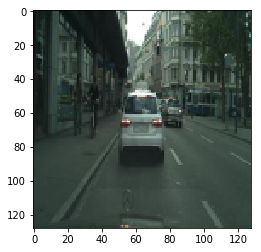

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


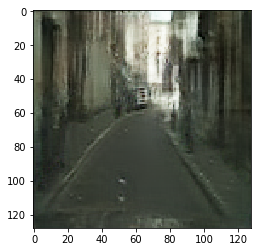

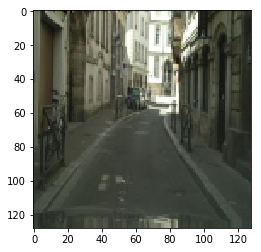

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


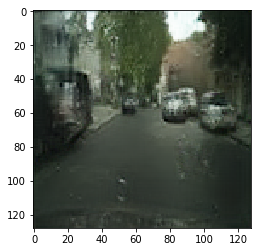

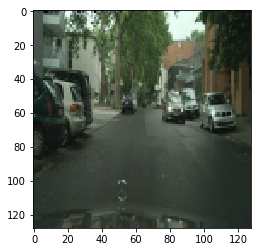

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


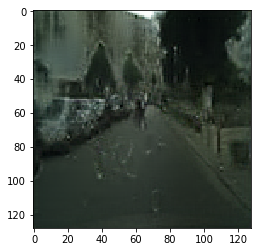

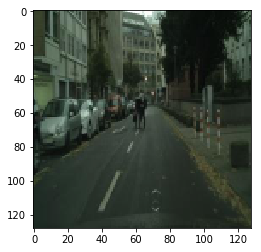

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


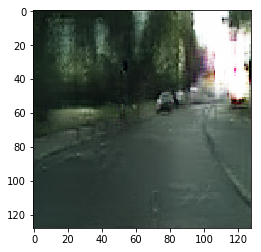

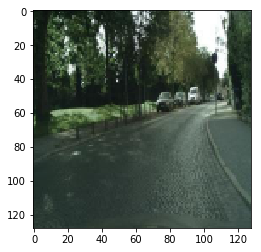

In [57]:
# Testing the GAN

for i in range(0,10):
    truth,labelled = load_images('edges2shoes',1,i+100)
    predict = g.predict(labelled)
    plt.imshow(predict[0])  
    plt.show()
    plt.imshow(truth[0])
    plt.show()



In [0]:
# Saving Model
g.save_weights('g.h5')
d.save_weights('Discriminator_weights.h5')
